# Combined number of scans

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
df_summary["TRIAL_TO_INCLUDE"] = df_main["TRIAL_TO_INCLUDE"]

In [11]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

## Sort clusters

### 7clusters

In [12]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [13]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [14]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [15]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [16]:
CLUSTER_STR_7 = [
    "TC-Straight", "TC-Curved-1", "TC-Curved-2",
    "CT-Straight", "CT-Curved-1", "CT-Curved-2"
]

## Spheroid names and colors

In [17]:
SPH_COLORS = ["w", "gainsboro", "darkgrey"]  # L, M, S

In [18]:
SPH_STR = ["L", "M", "S"]
SPH_LABEL = ["AR=2.9", "AR=1.3", "AR=1.1"]

In [19]:
sph_tcct = [f"{sph}_{tcct_type}" for sph, tcct_type in zip(["L", "M", "S"]*2, ["TC"]*3+["CT"]*3)]

In [20]:
sph_tcct

['L_TC', 'M_TC', 'S_TC', 'L_CT', 'M_CT', 'S_CT']

## Assemble plot

In [21]:
scan_bins = np.arange(0, 27) - 0.5
scan_x = (scan_bins[:-1] + scan_bins[1:])/2
scan_bar_width = 0.25

In [22]:
# Vertical shift for CT clusters
vert_shift = 0.4

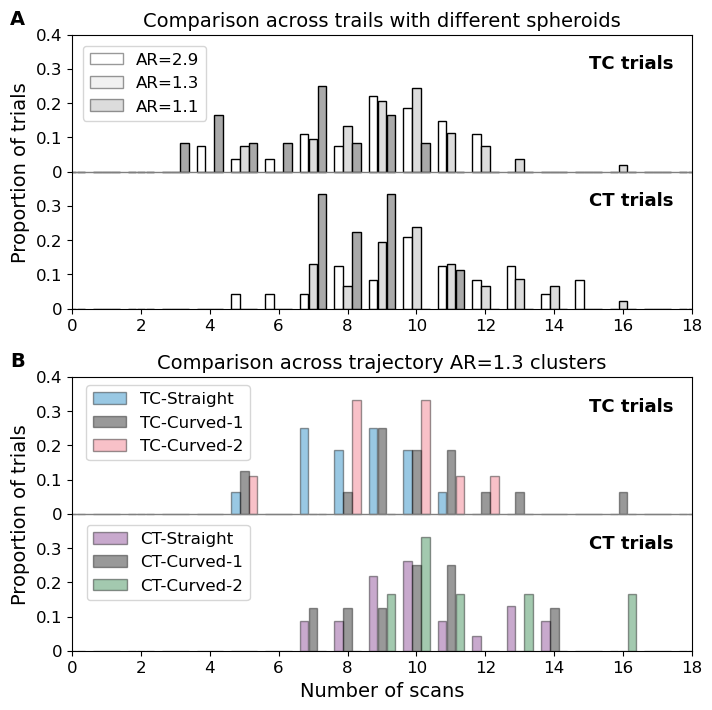

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), facecolor="w")

fig.subplots_adjust(hspace=0.25)


# Different spheroids
# ===================================
ax_sph = ax[0]
# ===================================
for sph_seq, sph in enumerate(["L", "M", "S"]):
    
    for tcct_type in ["TC", "CT"]:

        # CT trials -- TOP panel
        sph_index = (
        (df_summary["SPHEROID"] == sph)
            & (df_summary["CHOICE"] == 1)
            & df_summary["TRIAL_TO_INCLUDE"]
            & (df_summary["TCCT"] == tcct_type)
        )
        df_wanted = df_summary[sph_index].copy()
        ta, _ = np.histogram(df_wanted["scan_combined"]-1, bins=scan_bins, density=True)

        # Horiztonal bar shift
        if sph_seq == 0:
            shift = -scan_bar_width-0.01 # if L shift bar leftward
        elif sph_seq == 2:
            shift = scan_bar_width+0.01  # if S shift bar rightward
        else:
            shift = 0  # if M does not shift

        bottom = 0 if tcct_type=="CT" else vert_shift  # vertical shift
        ax_sph.bar(
            scan_x + shift, ta, bottom=bottom, width=scan_bar_width, 
            alpha=1, color=SPH_COLORS[sph_seq], edgecolor="k"
        )

# Horizontal divide line
ax_sph.axhline(vert_shift, color="grey", lw=1)
    

ax_sph.set_xlim(0, 12)
ax_sph.set_xticks(np.arange(0, 13, 2))
ax_sph.set_xticklabels(np.arange(0, 13, 2), fontsize=12)
ax_sph.set_yticks(np.array([0, 0.25, 0.5, vert_shift, vert_shift+0.25, vert_shift+0.5]))
ax_sph.set_yticklabels([0, 0.25, 0.5, 0, 0.25, 0.5], fontsize=12)
ax_sph.set_ylim(0, vert_shift*2)



# Different clusters in AR=1.3 trials
# ===================================
ax_clu = ax[1]
# ===================================
for seq in range(6):
    ta_cluster, _ = np.histogram(
        df_cluster_clean_7[seq]["scan_combined"]-1, bins=scan_bins, density=True
    )

    # Horiztonal bar shift
    if np.mod(seq, 3) == 0:
        shift = -scan_bar_width-0.01 # if straight shift bar leftward
    elif np.mod(seq, 3) == 1:
        shift = 0  # if curved 1 do not shift bar
    else:
        shift = scan_bar_width+0.01  # if curved 2 shift bar rightward
    
    bottom = vert_shift if seq <= 2 else 0

    ax_clu.bar(
        x=scan_x + shift, height=ta_cluster, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq], label=CLUSTER_STR_7[seq],
    )
    
ax_clu.axhline(vert_shift, color="grey", lw=1)



# Axis labels
ax_sph.set_ylim(0, 0.25)
ax_sph.set_yticks(np.arange(0, 0.85, 0.1))
ax_sph.set_yticklabels([0, 0.1, 0.2, 0.3, 0, 0.1, 0.2, 0.3, 0.4], fontsize=12)

ax_clu.set_ylim(0, 0.8)
ax_clu.set_yticks(np.arange(0, 0.9, 0.1))
ax_clu.set_yticklabels([0, 0.1, 0.2, 0.3, 0, 0.1, 0.2, 0.3, 0.4], fontsize=12)

for axx in [ax_sph, ax_clu]:
    axx.set_xticks(np.arange(0, 25, 2))
    axx.set_xticklabels(np.arange(0, 25, 2), fontsize=12)
    axx.set_xlim(0, 18)

ax_sph.set_title("Comparison across trails with different spheroids", fontsize=14)
ax_clu.set_title("Comparison across trajectory AR=1.3 clusters", fontsize=14)

ax_clu.set_xlabel("Number of scans", fontsize=14)
ax_sph.set_ylabel("Proportion of trials", fontsize=14)
ax_clu.set_ylabel("Proportion of trials", fontsize=14)



# Plot legend
ax_sph.text(15, 0.7, "TC trials", fontsize=13, fontweight="bold")
ax_sph.text(15, 0.3, "CT trials", fontsize=13, fontweight="bold")
ax_clu.text(15, 0.7, "TC trials", fontsize=13, fontweight="bold")
ax_clu.text(15, 0.3, "CT trials", fontsize=13, fontweight="bold")


ax_sph_pos = ax_sph.get_position()
ax_clu_pos = ax_clu.get_position()

ax_sph_mock = plt.axes(ax_sph.get_position())
ax_sph_mock.patch.set_alpha(0)
plt.axis("off")
for seq in range(3):
    ax_sph_mock.bar(np.nan, np.nan,
        alpha=0.4, edgecolor="k", color=SPH_COLORS[seq], label=SPH_LABEL[seq])
ax_sph_mock.legend(bbox_to_anchor=(0.23, 0.99), fontsize=12)

ax_clu_mock1 = plt.axes(ax_clu_pos)
ax_clu_mock1.patch.set_alpha(0)
plt.axis("off")
for seq in range(3):
    ax_clu_mock1.bar(np.nan, np.nan,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq], label=CLUSTER_STR_7[seq])
ax_clu_mock1.legend(bbox_to_anchor=(0.3, 1), fontsize=12)

ax_clu_mock2 = plt.axes(ax_clu_pos)
ax_clu_mock2.patch.set_alpha(0)
plt.axis("off")
for seq in range(3):
    ax_clu_mock2.bar(np.nan, np.nan,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq+3], label=CLUSTER_STR_7[seq+3])
ax_clu_mock2.legend(bbox_to_anchor=(0.3, 0.49), fontsize=12)


# Add panel labels
ax_sph.text(-1.8, 0.83, "A", fontsize=14, fontweight="bold")
ax_clu.text(-1.8, 0.83, "B", fontsize=14, fontweight="bold")



plt.show()

fig.savefig(fig_path / "fig_combined_scan.png", dpi=300, bbox_inches="tight")
